# Statistical Tests

This notebook is used to perform the statistical tests as reported in the paper (in addition to a few extra ones).

In [2]:
from plot_funcs import (get_results, plot_avg_ranks, get_mean_avg_ranks, get_ranks_sizes, get_highest_performing_df, get_cut_off_df,
                        get_across_ranks, get_intra_pipeline_df, get_single_vs_multiple_df, get_results_df)
from statsmodels.formula.api import ols, rlm
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from funcs import save_stats_summary, save_results_table

In [3]:
results = get_results('../exp/results')
static = {'random': True, 'base': True, 'fs': True, 'ico': True}

Found: 64530 Incomplete: 0


# Averaged Performance-Size Scaling

This test corresponds to Figure 2 in the manuscript, what we want to test here is the relationship between Mean Rank and size and then as further influenced by type of parcellation.

In [4]:
r_df = get_ranks_sizes(results, log=True,
                       threshold=True, **static)
model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'base_results1')
print(model.pvalues)

model.summary()

1 -13
Smallest size: 7.0
Largest size: 4000.0
Intercept                                       1.982025e-220
C(Parcellation_Type)[T.Freesurfer Extracted]     6.906313e-01
C(Parcellation_Type)[T.Icosahedron]              8.274644e-01
C(Parcellation_Type)[T.Random]                   4.040000e-08
Size                                            1.293155e-101
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     462.8
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          3.57e-100
Time:                        11:43:44   Log-Likelihood:                 294.77
No. Observations:                 206   AIC:                            -579.5
Df Residuals:                     201   BIC:                            -562.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        2.6123      0.015    172.573      0.000       2.582       2.642
C(Parcellation_Type)[T.Freesurfer Extracted]     0.0167      0.042      0.399      0.691      -0.066       0.099
C(Parcellation_Type)[T.Icosahedron]             -0.0055      0.025     -0.218      0.827      -0.055       0.044
C(Parcellation_Type)[T.Random]                   0.0494      0.009      5.709      0.000       0.032       0.066
Size                                            -0.2782      0.007    -42.080      0.000      -0.291      -0.265
==============================================================================
Omnibus:                        2.407   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                2.234
Skew:                           0.101   Prob(JB):                        0.327
Kurtosis:                       3.469   Cond. No.                         26.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only the difference between existing and random have enough statistical power. Viz just the different fits for Existing vs. Random:

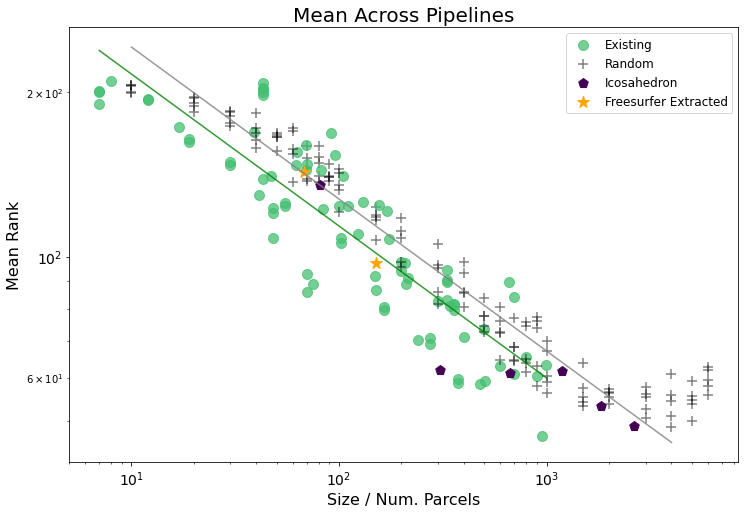

In [5]:
# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
e_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Existing']
r_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Random']

# Get pred fit lines
e_fit = 10 ** model.params.Intercept * (e_size **(model.params.Size))

r_intercept = 10 ** (model.params.Intercept + model.params['C(Parcellation_Type)[T.Random]'])
r_fit = r_intercept * (r_size **(model.params.Size))

# Plot lines of fit
ax.plot(e_size, e_fit, color='green', alpha=.8)
ax.plot(r_size, r_fit, color='gray', alpha=.8)

# Add main plot
plot_avg_ranks(results,
               log=True,
               ax=ax, **static)

plt.savefig('Figures/base_results_fit1.png', dpi=300, bbox_inches='tight')

We want to next check if there is a possible interaction between parcellation type and size.

In [6]:
sns.lmplot(y='Mean_Rank', x='Size', data=r_df, hue='Parcellation_Type')
plt.title('LogLog OLS By Parcellation')
plt.savefig('Figures/base_results_fit2.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'base_results2')
print(model.pvalues)
model.summary()

Intercept                                            1.146780e-169
C(Parcellation_Type)[T.Freesurfer Extracted]          3.930177e-01
C(Parcellation_Type)[T.Icosahedron]                   5.976996e-01
C(Parcellation_Type)[T.Random]                        2.141784e-01
Size                                                  3.050137e-56
Size:C(Parcellation_Type)[T.Freesurfer Extracted]     4.101729e-01
Size:C(Parcellation_Type)[T.Icosahedron]              6.135194e-01
Size:C(Parcellation_Type)[T.Random]                   7.940296e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     262.0
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           1.85e-96
Time:                        11:43:49   Log-Likelihood:                 295.28
No. Observations:                 206   AIC:                            -574.6
Df Residuals:                     198   BIC:                            -547.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             2.6186      0.027     97.916      0.000       2.566       2.671
C(Parcellation_Type)[T.Freesurfer Extracted]          0.4179      0.488      0.856      0.393      -0.545       1.380
C(Parcellation_Type)[T.Icosahedron]                  -0.0729      0.138     -0.529      0.598      -0.345       0.199
C(Parcellation_Type)[T.Random]                        0.0411      0.033      1.246      0.214      -0.024       0.106
Size                                                 -0.2813      0.013    -22.422      0.000      -0.306      -0.257
Size:C(Parcellation_Type)[T.Freesurfer Extracted]    -0.2002      0.243     -0.825      0.410      -0.679       0.278
Size:C(Parcellation_Type)[T.Icosahedron]              0.0246      0.049      0.506      0.614      -0.071       0.121
Size:C(Parcellation_Type)[T.Random]                   0.0039      0.015      0.261      0.794      -0.025       0.033
==============================================================================
Omnibus:                        2.366   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.306   Jarque-Bera (JB):                2.158
Skew:                           0.108   Prob(JB):                        0.340
Kurtosis:                       3.452   Cond. No.                         404.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No interactions are signifigant here.

Next, we will see how the results change when using robust regression and no thresholding, where thresholding = the procedure for selecting the region in which the scaling holds.

In [7]:
r_df = get_ranks_sizes(results, log=True, **static)

model = rlm('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Intercept                                       0.000000e+00
C(Parcellation_Type)[T.Freesurfer Extracted]    6.245984e-01
C(Parcellation_Type)[T.Icosahedron]             7.260774e-01
C(Parcellation_Type)[T.Random]                  9.421043e-10
Size                                            0.000000e+00
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              Mean_Rank   No. Observations:                  220
Model:                            RLM   Df Residuals:                      215
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 22 Jun 2021                                         
Time:                        11:43:49                                         
No. Iterations:                    20                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        2.5668      0.014    179.239      0.000       2.539       2.595
C(Parcellation_Type)[T.Freesurfer Extracted]     0.0217      0.044      0.489      0.625      -0.065       0.109
C(Parcellation_Type)[T.Icosahedron]             -0.0093      0.027     -0.350      0.726      -0.061       0.043
C(Parcellation_Type)[T.Random]                   0.0557      0.009      6.119      0.000       0.038       0.074
Size                                            -0.2580      0.006    -42.077      0.000      -0.270      -0.246
================================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

Let's view some specific raw results, as well as save a copy of the raw results table

In [8]:
r_df = get_ranks_sizes(results, log=False, keep_full_name=True, add_raw=True, **static)

# Show top result
display(r_df.sort_values('Mean_Rank').iloc[[0]])

# Show the two freesurfer
display(r_df[r_df['full_name'] == 'freesurfer_destr'])
display(r_df[r_df['full_name'] == 'freesurfer_desikan'])

# Save raw results
save_results_table(r_df, name='raw_results1')

Parcellation_Type  Mean_Rank  Size        r2   roc_auc  \
194          Existing  46.888889   949  0.085201  0.629424   

                       full_name  
194  vol-resamp-difumo-1024_prob

Parcellation_Type  Mean_Rank  Size        r2  roc_auc         full_name
11  Freesurfer Extracted  97.422222   150  0.073573  0.61954  freesurfer_destr

Parcellation_Type   Mean_Rank  Size        r2   roc_auc  \
10  Freesurfer Extracted  142.592593    68  0.061316  0.606063   

             full_name  
10  freesurfer_desikan

# Choice of Pipeline

### Intra-Pipeline Comparison

In [ ]:
intra_pipe_df = get_intra_pipeline_df(results, log=True,
                                      threshold=True, **static)

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Model', data=intra_pipe_df)
plt.title('Intra pipe')

# Run stats
model = ols('Mean_Rank ~ Size * C(Model)', data=intra_pipe_df).fit()
print(model.pvalues)
model.summary()

### Inter-Pipeline

In [ ]:
inter_pipe_df = get_across_ranks(results, log=True, **static)

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Model', data=inter_pipe_df)
plt.title('Inter pipe')

model = ols('Mean_Rank ~ Size * C(Model)', data=inter_pipe_df).fit()
print(model.pvalues)
model.summary()

In [ ]:
print('Elastic intercept vs. SVM intercept')
model.params.Intercept, model.params.Intercept+model.params['C(Model)[T.svm]'], model.pvalues['C(Model)[T.svm]']

In [ ]:
print('Elastic size coef vs. SVM interaction')
model.params.Size, model.params.Size+model.params['Size:C(Model)[T.svm]'], model.pvalues['Size:C(Model)[T.svm]']

# Variation Across Target Variable

In [ ]:
r_df = get_ranks_sizes(results, avg_targets=False,
                       log=True, threshold=False, **static)

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
model.summary()

### Calculate IQR at every unique size, then fit a model explaining it in relation to size.

In [ ]:
def v(x):
    rl = x['Mean_Rank']
    return rl.quantile(.75) - rl.quantile(.25)
    
log_size_to_var = r_df.groupby('Size').apply(v)
ls_df = log_size_to_var.to_frame().reset_index().rename(columns={0: 'IQR'})


sns.lmplot(y='IQR', x='Size', data=ls_df)
plt.title('Size to IQR')

model = ols('IQR ~ Size', data=ls_df).fit()
print(model.pvalues)
model.summary()

### Compare thresholded R2 at 4000 and less between variation models

In [ ]:
r_df = get_ranks_sizes(results, avg_targets=False,
                       log=True, threshold=False, **static)
r_df = r_df[r_df['Size'] <= np.log10(4000)]

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
model.summary()

In [ ]:
r_df = get_ranks_sizes(results, avg_targets=True, log=True,
                       threshold=False, **static)
r_df = r_df[r_df['Size'] <= np.log10(4000)]

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
model.summary()

# Single vs. Multiple Parcellations

1. Compare Ensembles to Non-Ensembled Results

In [ ]:
r_df = get_single_vs_multiple_df(results, threshold=False, log=True,
                                 stacked=True,
                                 voted=True, grid=True,
                                 **static).reset_index()
# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='is_ensemble', data=r_df)
plt.title('If Ensemble')

model = ols('Mean_Rank ~ Size * C(is_ensemble)', data=r_df).fit()
print(model.pvalues)
model.summary()

In [ ]:
model.params.Intercept, model.params.Intercept + model.params['C(is_ensemble)[T.1]'], model.pvalues['C(is_ensemble)[T.1]']

In [ ]:
model.params.Size, model.params.Size + model.params['Size:C(is_ensemble)[T.1]'], model.pvalues['Size:C(is_ensemble)[T.1]']

2. Compare Stacked vs. Voted Results

In [ ]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False)

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Stacked vs. Voted')

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Make sure allowing for interactions is also not signifgant

In [ ]:
model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

3. Compare fixed size ensemble to across size ensemble

In [ ]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, by_group=False)
r_df['across_sizes'] = [1 if '-' in r else 0 for r in r_df.index]

sns.lmplot(x='Size', y='Mean_Rank', hue='across_sizes', data=r_df)
plt.title('Fixed vs. Across Sizes')

model = ols('Mean_Rank ~ Size + C(across_sizes)', data=r_df).fit()
print(model.pvalues)
model.summary()

Check for size interactions on only a subset where they start at the same size

In [ ]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, by_group=False)
r_df['across_sizes'] = [1 if '-' in r else 0 for r in r_df.index]
r_df = r_df[r_df['Size'] > 2.9]

sns.lmplot(x='Size', y='Mean_Rank', hue='across_sizes', data=r_df)
plt.title('Fixed vs. Across Sizes')

model = ols('Mean_Rank ~ Size * C(across_sizes)', data=r_df).fit()
print(model.pvalues)
model.summary()

4. Compare ‘Grid’ results to just random single parcellation results

In [ ]:
r_df = get_ranks_sizes(results, grid=True, random=True,
                       threshold=False, by_group=True, log=True)

# Get only random parcellations of the same size
g_sizes = r_df[r_df['Parcellation_Type'] == 'Grid']['Size']
g_max = g_sizes.max()
g_min = g_sizes.min()
print('restrict to:', round(10 ** g_min), round(10 ** g_max))
r_df = r_df[(r_df['Size'] >= g_min) & (r_df['Size'] <= g_max)]

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Grid vs. Random')

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

# Highest Performance

 Inter pipeline ensemble results, to show that SVM based ensembles outperform other pipelines, use as justification for including them in Figure 6.

In [ ]:
inter_pipe_df = get_across_ranks(results, drop_all=True,
                                 log=True, stacked=True, voted=True)

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Model', data=inter_pipe_df)
plt.title('Inter pipe ensemble')

# Model
model = ols('Mean_Rank ~ Size * C(Model)', data=inter_pipe_df).fit()
print(model.pvalues)
model.summary()

In [ ]:
# get DF
r_df = get_highest_performing_df(results)

# Do Threshold
r_df = get_cut_off_df(r_df)
print('Smallest size:', r_df.sort_values('Size').iloc[0].Size)
print('Largest size:', r_df.sort_values('Size').iloc[-1].Size)

# Setup for plot
r_df = r_df.reset_index()
r_df['Mean_Rank'] = np.log10(r_df['Mean_Rank'])
r_df['Size'] = np.log10(r_df['Size'])

sns.lmplot(y='Mean_Rank', x='Size', data=r_df, hue='Model')

# Model
model = ols('Mean_Rank ~ Size + C(Model)', data=r_df).fit()
print(model.pvalues)
model.summary()